In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tools import *

C:\Users\Fede\AppData\Local\Temp\ipykernel_7528\3245994473.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Dataset

The data used to train the model consist on steam reviews from the most relevant games on 20/2024 which can be found <a href='https://store.steampowered.com/games/?l=latam&flavor=contenthub_topsellers'> here</a>.

The first step is to get the game ids from the source, i was able to retrieve 224 reviews. Then the reviews of each game are obtained using the <a href='https://partner.steamgames.com/doc/store/getreviews'>Steam Api</a>

To get the reviews the following piece of code was used, then these are saved in the file reviews.csv . The amount of reviews are 59805. There are a lot of filters that can be applied on the reviews like:

- weighted_vote_score : Measure how useful is the review
- comment_count : The amount of comments asociated with the reviews
- votes_up : How many upvotes the review had
- votes_funny : The amount of votes of people that find that think the review is funny
 

In [2]:
# id_list = steam_ids_scrapper() #Obtenemos la lista de ids
# print(len(id_list))
# ids = id_list[:1000] #Busco los 500 primeros juegos mas relevantes

# # 'game_id', 'game_name', 'review', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score'
# reviews_data = {
#     'game_id':[], 
#     'game_name':[], 
#     'review':[], 
#     'voted_up':[], 
#     'votes_up':[],
#     'votes_funny':[],
#     'weighted_vote_score':[]
#     }

# for id in ids:
#     try:
#         revs_dict = id_reviews_scrapper(id=id,n_rev_per_game=400)
#     except requests.exceptions.HTTPError:
#         print(f'Problem with id {id} on id_reviews_scrapper')
#     else:
#         try:
#             rev_build = review_builder(revs_dict)
#         except requests.exceptions.HTTPError:
#             print(f'Problem with id {id} on review_builder')
#         else:
#             for key in list(reviews_data.keys()):
#                 reviews_data[key] = reviews_data[key] + rev_build[key]

In [3]:
path_1 = './reviews.csv'
path_2 = './reviews2.csv'
df_1 = pd.read_csv(path_1)
df_2 = pd.read_csv(path_2)
df1 = df_1.drop_duplicates(subset='review').reset_index(drop=True)
df2 = df_2.drop_duplicates(subset='review').reset_index(drop=True)
print(df2.drop_duplicates(subset='game_id').shape)
df = pd.concat([df2.reset_index(drop=True), df1.reset_index(drop=True)]).reset_index(drop=True)
df



(105, 7)


,game_id,game_name,review,voted_up,votes_up,votes_funny,weighted_vote_score
0,200710,Torchlight II,Yes I would recommend this game to others. So ...,True,68,7,0.872375
1,200710,Torchlight II,Play this instead of Diablo IV. No microtran...,True,173,12,0.866532
2,200710,Torchlight II,i regret my diablo 4 purchase,True,65,8,0.828379
3,200710,Torchlight II,gonn grab me some torchlight while waiting for...,True,27,1,0.772369
4,200710,Torchlight II,Great game.,True,36,6,0.768902
...,...,...,...,...,...,...,...
87702,1262240,NaN,ASI ASI,True,1,0,0.500000
87703,1262240,NaN,we want elements bruh,False,1,0,0.500000
87704,1262240,NaN,I'm not vegan,True,1,0,0.500000
87705,1262240,NaN,Space Cadet is the peak of multiplayer shooter...,True,1,0,0.500000


I found that using weighted_vote_score will drastically reduce the amount of reviews due that the mean si close to 0.58, also 75% are below of 0.6. A lot of reviews provide useful information, but seems not to be seen by many people, they have a weighted_vote_score of 0.5 instead other reviews that dont provide useful information and that are asociated with joke reviews get the most comments. 

In [4]:
df[df['votes_funny']==6274]

,game_id,game_name,review,voted_up,votes_up,votes_funny,weighted_vote_score
42628,1774580,STAR WARS Jedi: Survivor™,Runs like my ass after taco bell,False,5516,6274,0.91693


The example above shows that people seems to react more tho the funny reviews but the review doesent seems to give useful information about how good or bad the game is.

On the other hand, reviews with low score, no upvotes have a lot of content that could help to tell if the game is good or not

In [5]:
print(df.loc[87705,'review'])


Space Cadet is the peak of multiplayer shooter character design.


I decided then no to drop any review because i find that much of the data provided about the reviews doesent correlate much with the quality of it.

In [6]:
#Train model
df3 = df[['review','voted_up']].dropna()
# X_train, X_test, y_train, y_test = train_test_split(df3['review'], df3['voted_up'].astype(float), train_size=0.80, random_state=99)
X_train,y_train = df3['review'],df3['voted_up'].astype(float)
model_results = model_training(X_train,y_train)
# score_test = model_results['model'].score(X_test,y_test)


# Performance of the model

As a previous step for the model training TfdifVectorized is used. The most important params are the min_df=3 (minumun document frecuency), language and the n grams.

The model is trained using LogisticRegression using a grid search with cross 5 cross validation folds.  

The model achieves a score of 0.90 over the cross validation folds wich is considered good enough to use.

In [7]:
print(model_results['score'])
# print(score_test)

0.8803602987286927


The function model_training(X,y) returns a dict with 3 keys:
- model : The best model trained
- score : The best score of the model in all the cross validation folds
- words : A dictionary that contains:
    - index: Asociated with the indexes of the LogisticRegression Coefficients ordered asc
    - words: The feature names of the TfidfVectorizer analysis
    - coef: Coeficients of the LogisticRegression

The analysis is the following:

- The bigger an negative a coef is for a word, the more the word is related to a negative review
- The bigger and posititive a coef is for a word, the more the word is related to a positive review

In [8]:
words_df = pd.DataFrame(model_results['words'])
words_df.sort_values(by='coef')

,index,words,coef
0,0,boring,-12.009090
1,1,unplayable,-11.677715
2,2,refund,-11.294030
3,3,disappointing,-10.087258
4,4,poorly,-9.940684
...,...,...,...
227173,227173,perfect,8.496007
227174,227174,10 10,9.876802
227175,227175,amazing,9.981189
227176,227176,masterpiece,11.366384


Here we have the top 50 most relevant terms both in positive (red) and negative (blue) reviews

C:\Users\Fede\AppData\Local\Temp\ipykernel_7528\160219214.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels,rotation=90)


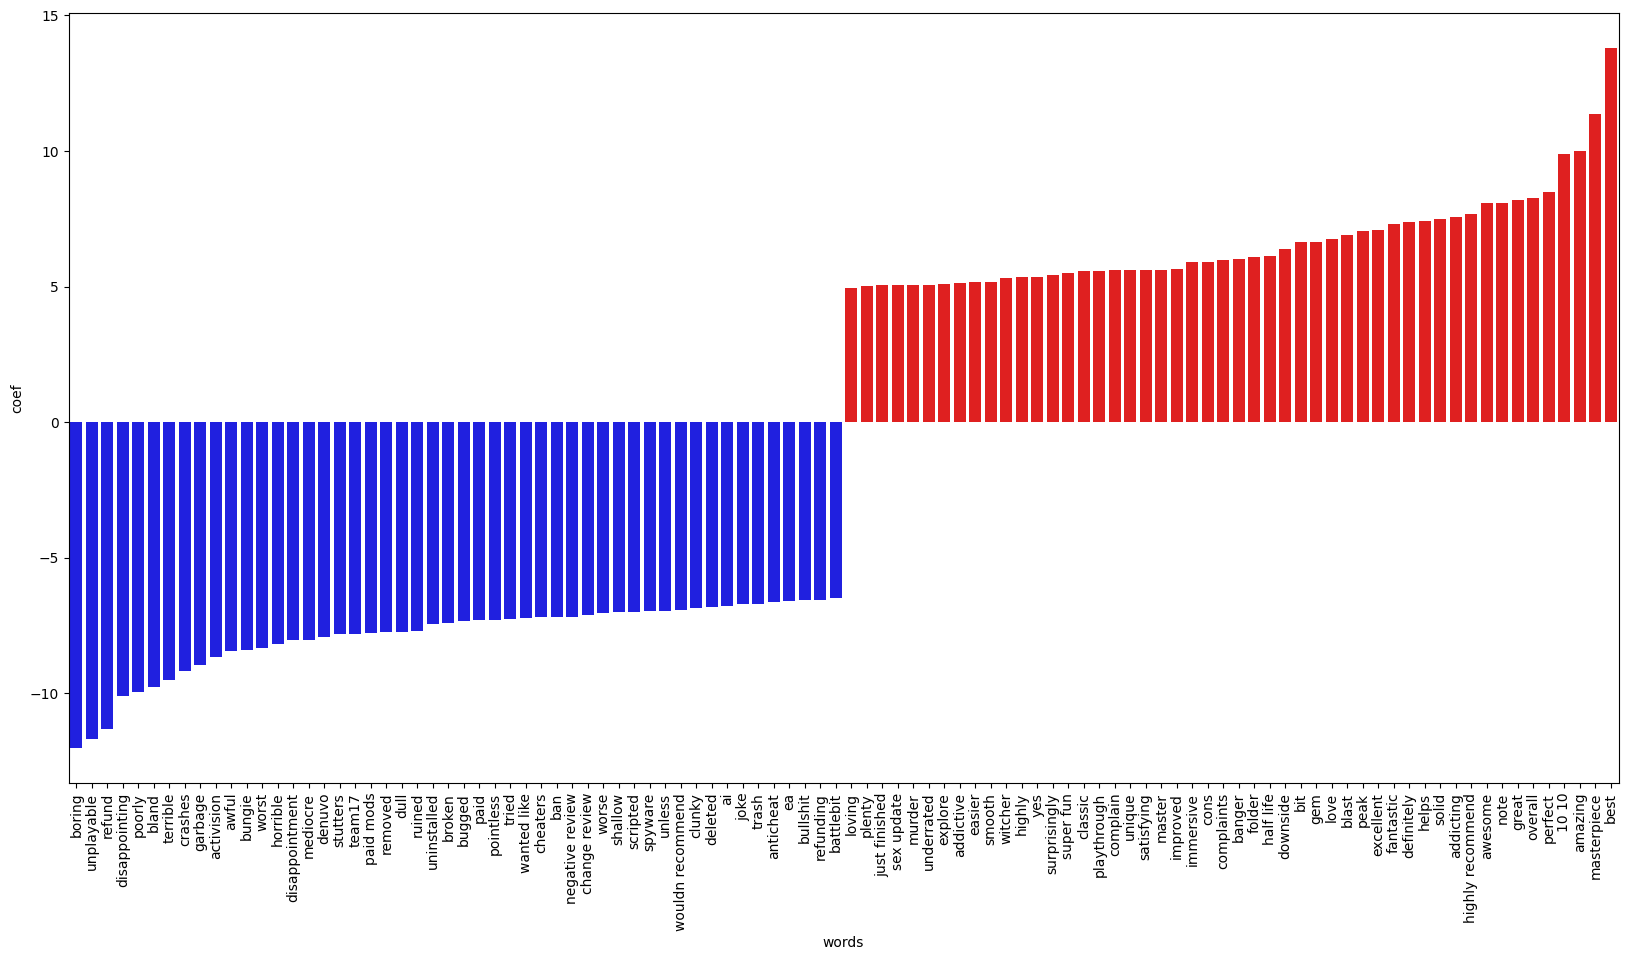

In [9]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)


sns.barplot(x=words_df['words'][:50],y=words_df['coef'][:50], color='blue')
sns.barplot(x=words_df['words'][-50:],y=words_df['coef'][-50:], color='red')
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels,rotation=90)
#plt.savefig('tfidf_general_analysis.png')
plt.show()

The model is going to be used to predict the outcome of a review as positive or negative. Yet there is another analysis that could be performed. We can utilize video game slang words to filter for videogame terms that could be relevant in classifiying a game as good or bad.

A list of game slang words can be found in <a href='https://en.wikipedia.org/wiki/Glossary_of_video_game_terms'>Wikipedia</a> , to find this terms the function wikipedia_slang() is used. 

Using the output of the above function, which are the slang words (game_slang) found in the reviews, we will compare them using the words_df (see in the cell above) through the function game_slang_analysis(game_slang=game_slang, words_df=words_df). This function will filter the words_df dataframe using the game_slang words and then will clasify each word as:

- very bad 
- bad 
- more or less bad
- more or less good
- good
- very good

Here i decid to calibrate the interval where each of the words belong. Only words closest to the negativest coef are considered very bad, and the same with words considered very good but with the positive coef. A lot of the words will fall into the categories of more or less bad and more or less good. These intervals can be calibrated using the interval_calibrator function.


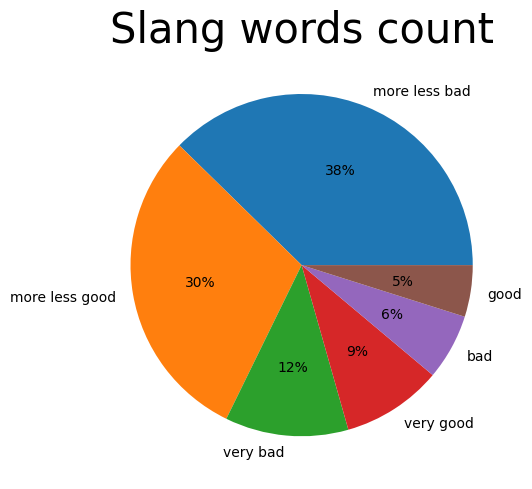

In [56]:
slang = wikipedia_slang(exclude_words=[])
classification = game_slang_analysis(words_df=words_df,game_slang=slang)
general_pie_graph(classification)

# Analysis for a particular Game

In [12]:
#Get the reviews of a game 
id = 1222690
reviews = review_builder(id_reviews_scrapper(id=id, n_rev_per_game=300))
reviews = pd.DataFrame(reviews)

#Get all the slang words of the reviews of a game

game_slang = game_slang_filter(reviews_df=reviews)



#Model Results:
best_model = model_results['model']
words_df = pd.DataFrame(model_results['words'])

The quality_review_finder, will provide the reviews with n_score minimun slang words appearance in the reviews. This way we ensure to get the most informative ones.

Also an score will be provided using the algorithm , for positive reviews the score is 1 and for negative is -1.

In [58]:
#Get the most informative reviews
quality_reviews = quality_review_finder(reviews=reviews, model_results=model_results, n_score=10)



In [59]:
scores = best_model.predict(quality_reviews['reviews'])


In [60]:
df_dict = {'reviews':quality_reviews['reviews'], 'scores':scores}
df_dict = pd.DataFrame(df_dict).replace(to_replace=0.0, value=-1.0)
df_dict

,reviews,scores
0,"""The Maker's will is not always clear, but we ...",1.0
1,I really like Dragon Age. \n\nI've even read s...,-1.0
2,Inquisition is a fun return to the chaotic wor...,1.0
3,With all the news that's been coming out about...,1.0
4,dragon age Inquisition review\nive put probabl...,1.0
5,Dragon Age Inquisition is fantasy Mass Effect ...,1.0
6,Pros:\n- story and characters\n- basic gamepla...,-1.0
7,---{ Graphics }---\nVery good - I enjoyed the ...,1.0


In [63]:
print(df_dict.loc[4,'reviews'])

dragon age Inquisition review
ive put probably over 1200 hours minimum into this game between both console and PC at this time
Alright there are many pros and cons for this game most of it being pros imo only massive downside is you are forced to use the shitstain EA app so ifs that a deal breaker dont read the rest of my review
Pros
edit: Use the dragon age keep site if you want to customise the history of your world before you create a character edit end:
Game runs very well and the graphics are pretty damn good even now almost a decade later and unlike previous dragon age games not everything has this weird gray tint to it
The price is worth it, especially right now as its on for less than 5 dollars and it includes all the dlc and will stay on sale til september 25th of 2023
Locations are massive and have a lotta things to go and grab
Romances are solid and some of them might be better than the ones from mass effect
Companions are also great
Boss Battles are pretty good but sometime

Using the quality_analysis() function we analyze the impact of each slang word both in positive and negative reviews. The more a work appears in positive reviews the more positive the score is. Same for negative reviews and words associated with it.

In [75]:
quality_analysis = quality_analysis(quality_reviews)


C:\Users\Fede\AppData\Local\Temp\ipykernel_7528\3130665449.py:671: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels,rotation=90)


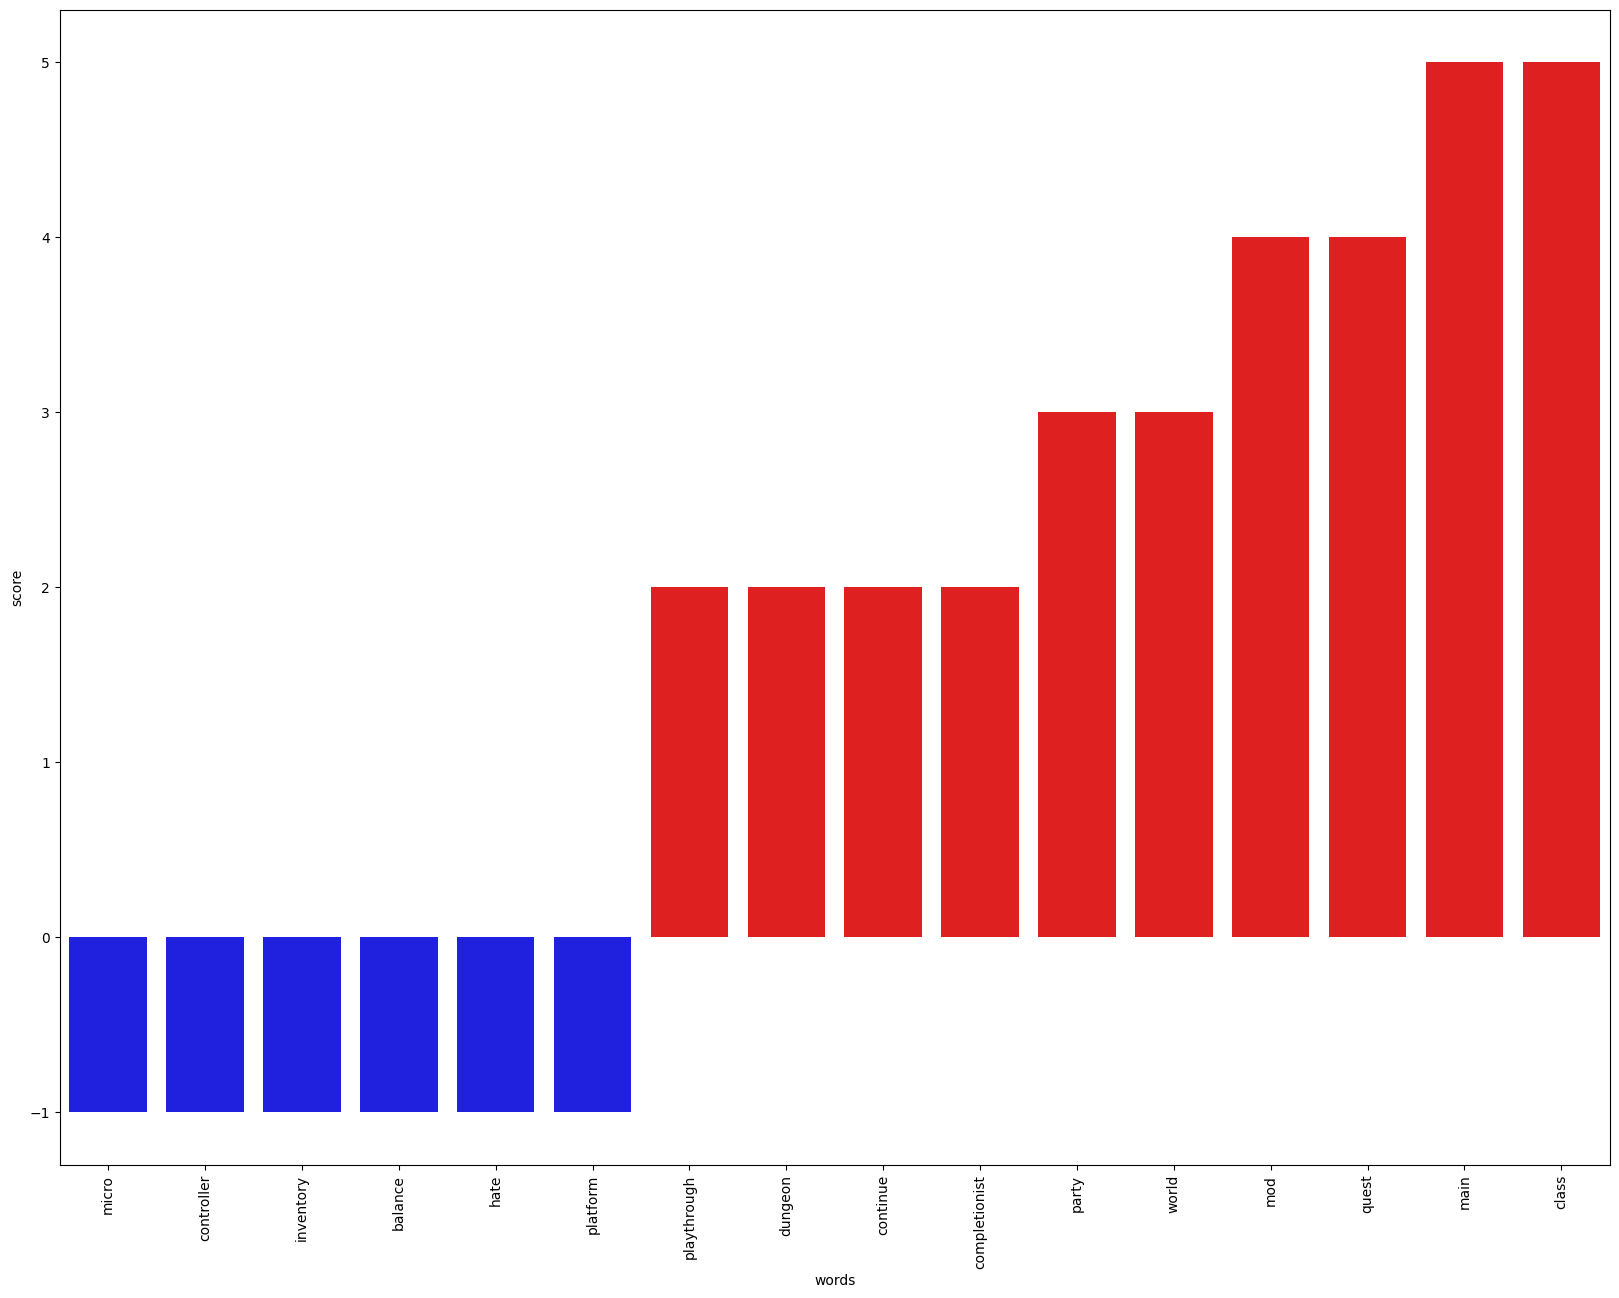

In [71]:
quality_analysis_plotter(quality_analysis['quality_word_scores'],n_words=10)

Also an analysis of how many times a slang word appear in the reviews can be performed.

C:\Users\Fede\AppData\Local\Temp\ipykernel_7528\2447013988.py:688: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels,rotation=90)


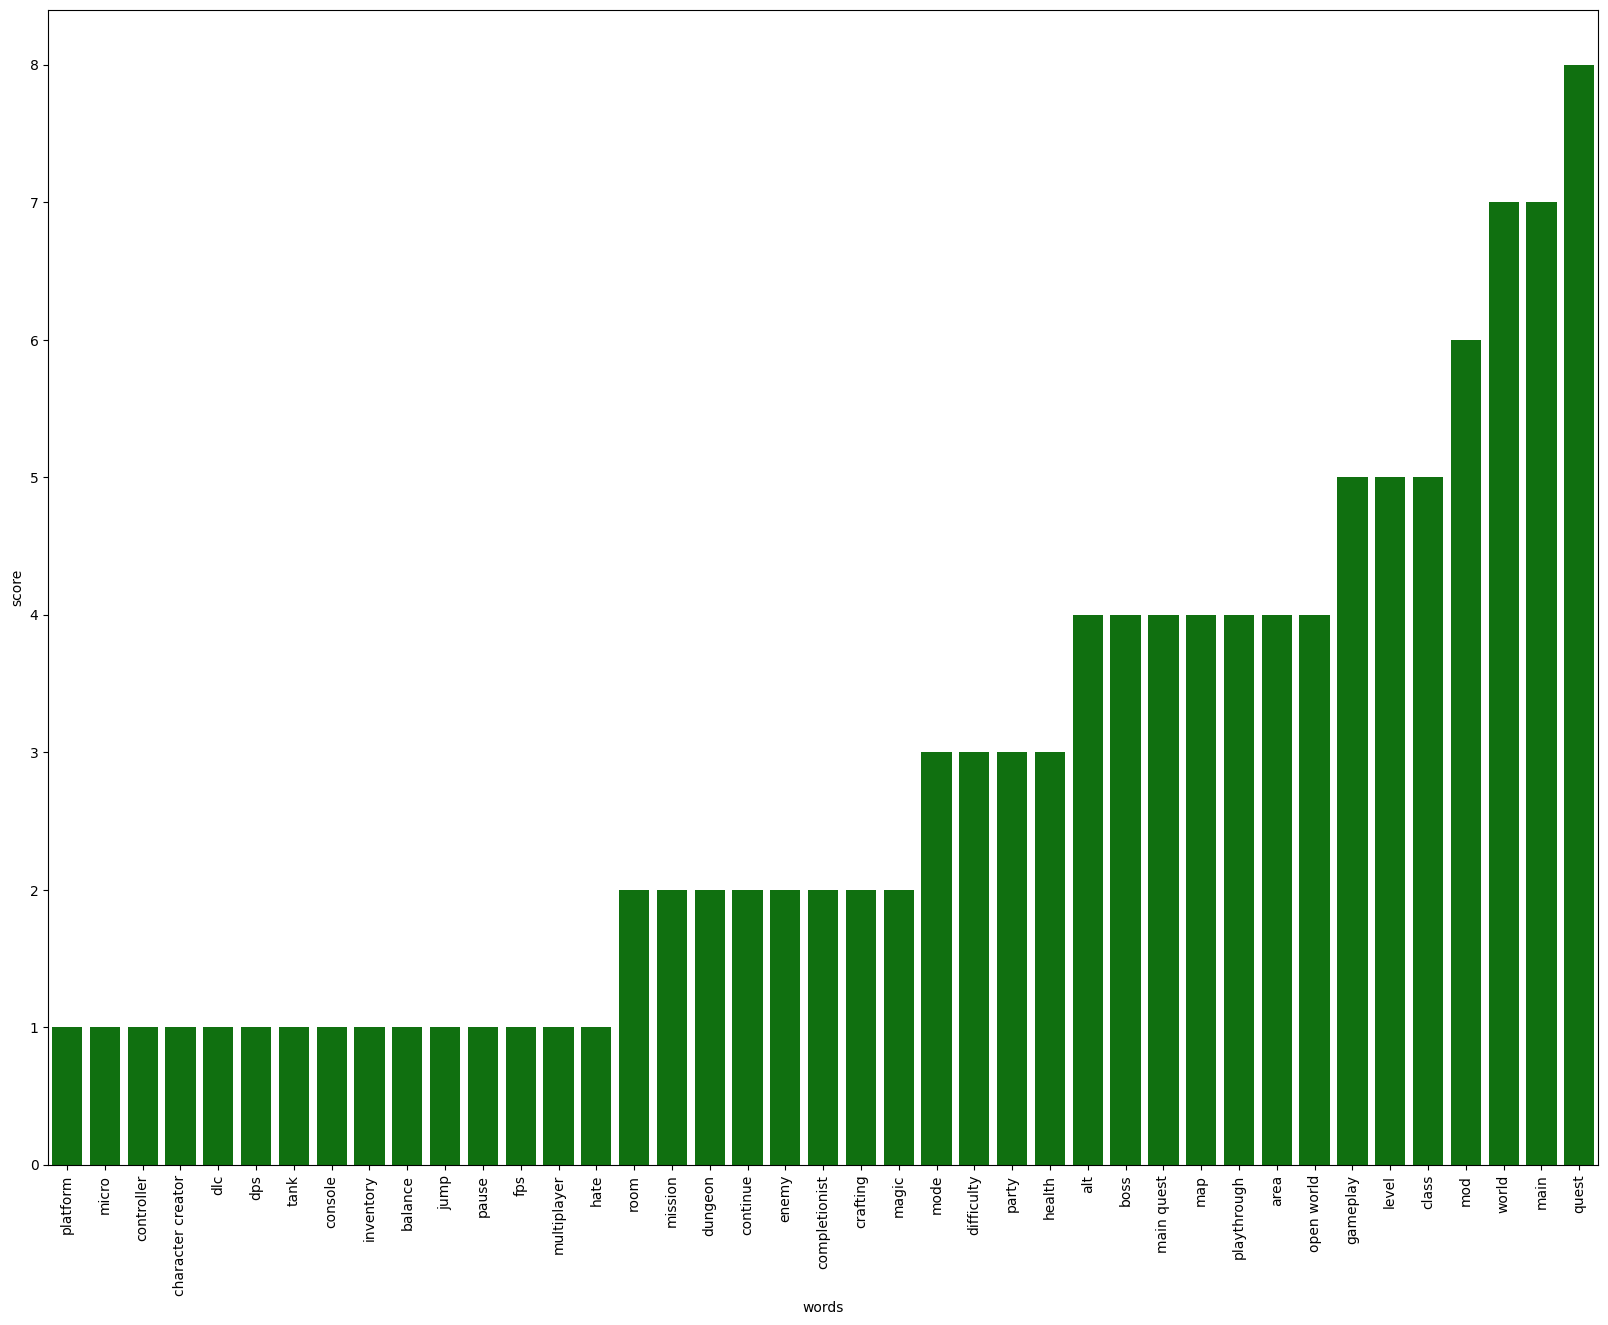

In [76]:
quality_distribution_plotter(quality_analysis['distribution_values'])

Below we have the analysis of 6 video games compared with the results provided by Steam. Because the most recent reviews are used in the analysis the prediction scores are strongly related with the recent column values of the steam reviews.

In [77]:
def slang_statistics(id:int, n_reviews:int, model_results):

    #Get the reviews of a game to calculate the score
    reviews = review_builder(id_reviews_scrapper(id=id, n_rev_per_game=n_reviews))
    reviews = pd.DataFrame(reviews)
 
    #Model Results:
    best_model = model_results['model']
    words_df = pd.DataFrame(model_results['words'])

    #Predigo en base a las reviews el score
    score = best_model.predict(reviews['review']).sum()/len(best_model.predict(reviews['review']))
    game_name = steam_id_name_finder(id)
    return {'score':score, 'name':game_name}

In [78]:
id_s = [1599340, 678950, 447040, 1145360, 606280, 1172470]
steam_scores = ['mostly positive','very postive','very postive','extremely positive','mostly positive', 'mostly positive']
recent_scores = ['varied', 'very postive', 'very postive', 'extremely positive', 'mostly positive', 'varied']
elements = list(zip(id_s,steam_scores))
results = {'name':[],'prediction':[],'steam_results':[]}

for e in elements:
    id = e[0]
    slang_class = slang_statistics(id=id, model_results=model_results, n_reviews=500)
    results['name'].append(slang_class['name'])
    results['prediction'].append(slang_class['score']*100 )
    results['steam_results'].append(e[1])
results['recent'] = recent_scores
pd.DataFrame(results)

,name,prediction,steam_results,recent
0,Lost Ark,28.6,mostly positive,varied
1,DRAGON BALL FighterZ,93.0,very postive,very postive
2,None,73.2,very postive,very postive
3,Hades,98.2,extremely positive,extremely positive
4,Darksiders III,75.4,mostly positive,mostly positive
5,Apex Legends,69.6,mostly positive,varied


# Conclussion

- Reviews given by the comunity are very useful for determinig if a game is good or bad, but the interaction of the people with the reviews, making a review more determinant than others sometimes is related with the humor of the video game comunity. The scores and related information provided by steam for the reviews not always help to find if a reviw is good or bad regarding the appreciation of a game. An algorythim provided by sentiment analysis could help to identy the key terms that tell if a game is good or bad based both in the comunity an personal interests of a player.

- Identify game slang words in the reviews could help improve the users quest to find if a game is wether good or bad. Presented in order of relevance could help a buyer to look for personal interests regarding the enjoyement of a particular game. 